In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 50
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = './mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'one' 'right' 'stop' 'two' 'up' 'yes']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Using 2000 files for validation.

label names: ['down' 'go' 'left' 'no' 'one' 'right' 'stop' 'two' 'up' 'yes']


In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


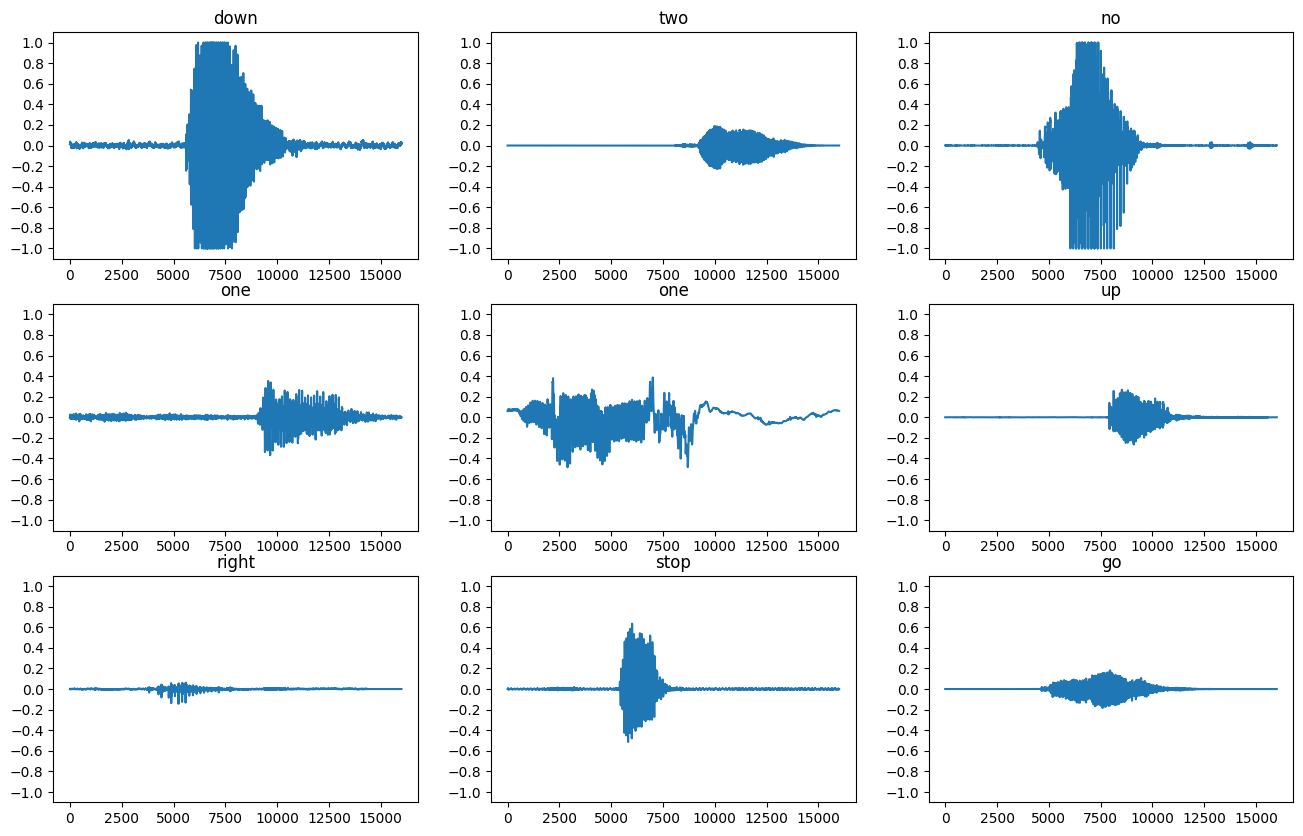

In [9]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [10]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [11]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: two
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [12]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

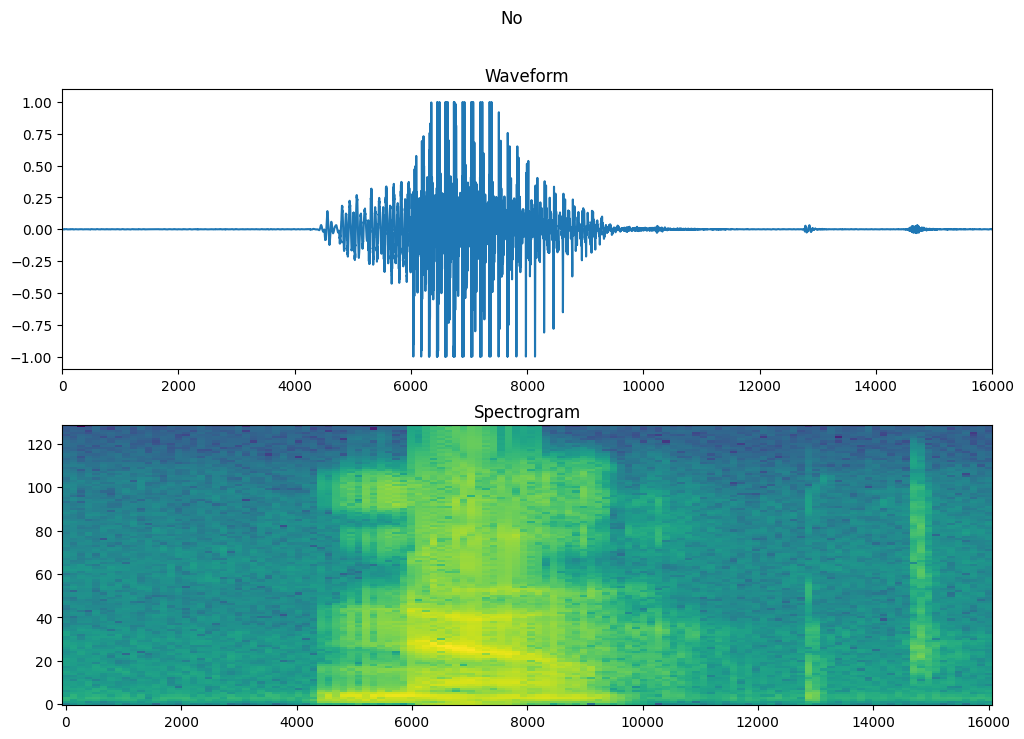

In [13]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [14]:
def make_spec_ds(ds):
  return ds.map(map_func=lambda audio, label:(get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

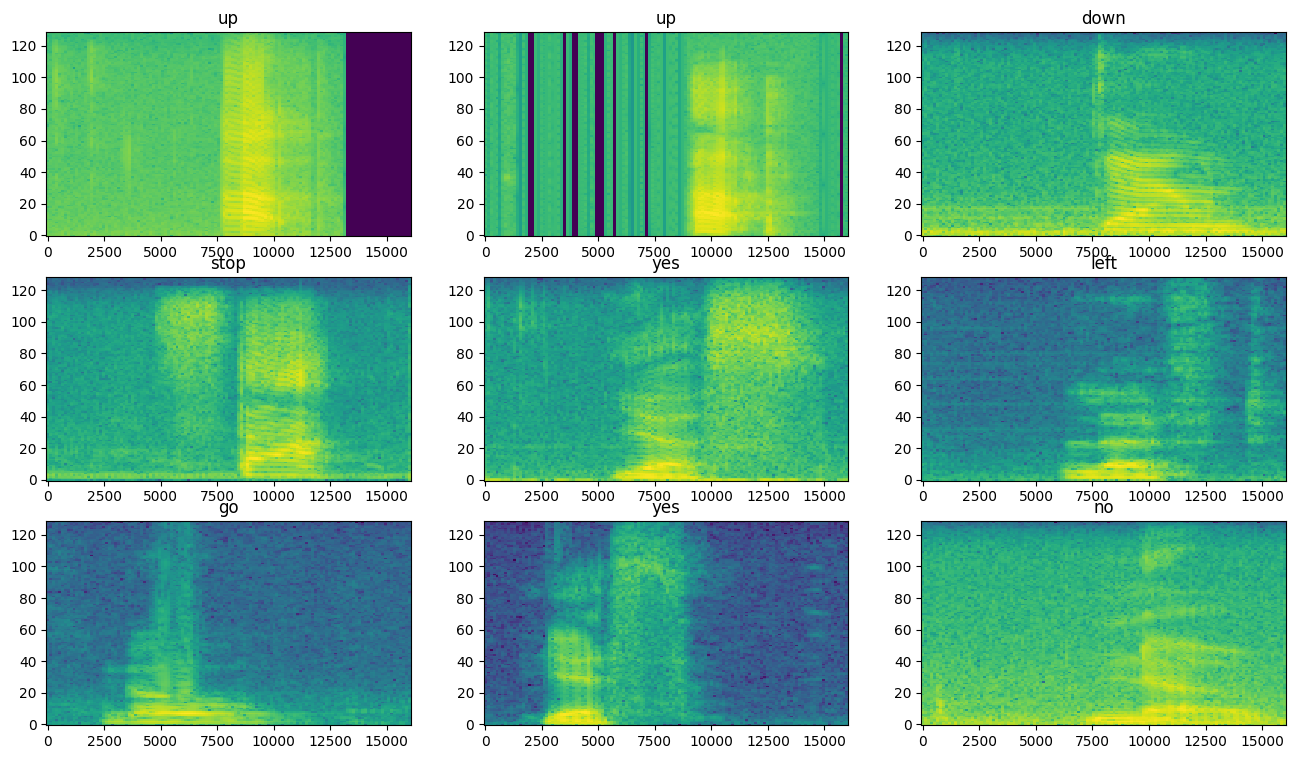

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## model and traing

In [18]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [18]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)         

In [19]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer,
    # 64 filters outputs, 3 kernal size
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

Input shape: (124, 129, 1)


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [33]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    # Verbosity mode. 0: silent, 1: progress bar, 2: one line per epoch.
    # Number of epochs with no improvement after which training will be stopped.
)

Epoch 1/10


100/100 [==============================] - 140s 1s/step - loss: 1.6181 - accuracy: 0.4256 - val_loss: 1.0342 - val_accuracy: 0.7174
Epoch 2/10
100/100 [==============================] - 158s 2s/step - loss: 0.8970 - accuracy: 0.7003 - val_loss: 0.6319 - val_accuracy: 0.8203
Epoch 3/10
100/100 [==============================] - 151s 2s/step - loss: 0.6245 - accuracy: 0.7952 - val_loss: 0.5644 - val_accuracy: 0.8438
Epoch 4/10
100/100 [==============================] - 154s 2s/step - loss: 0.4791 - accuracy: 0.8413 - val_loss: 0.5264 - val_accuracy: 0.8581
Epoch 5/10
100/100 [==============================] - 201s 2s/step - loss: 0.3752 - accuracy: 0.8745 - val_loss: 0.4624 - val_accuracy: 0.8750
Epoch 6/10
100/100 [==============================] - 458s 5s/step - loss: 0.3173 - accuracy: 0.8947 - val_loss: 0.4701 - val_accuracy: 0.8594
Epoch 7/10
100/100 [==============================] - 172s 2s/step - loss: 0.2720 - accuracy: 0.9095 - val_loss: 0.4595 - val_accuracy: 0.8724
Epoch 8/10

In [19]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(48, 48),
    norm_layer,
    layers.Conv2D(48, 3, activation='relu'),
    # norm_layer,
    layers.Conv2D(96, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),  # Additional Conv2D layer
    # norm_layer,
    # layers.Conv2D(512, 3, activation='relu'),  # Additional Conv2D layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # norm_layer,
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

Input shape: (124, 129, 1)




In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    # Verbosity mode. 0: silent, 1: progress bar, 2: one line per epoch.
    # Number of epochs with no improvement after which training will be stopped.
)

Epoch 1/10


125/125 [==============================] - 247s 2s/step - loss: 1.7273 - accuracy: 0.4238 - val_loss: 0.9776 - val_accuracy: 0.7234
Epoch 2/10
125/125 [==============================] - 254s 2s/step - loss: 0.9023 - accuracy: 0.7082 - val_loss: 0.6553 - val_accuracy: 0.7900
Epoch 3/10
125/125 [==============================] - 289s 2s/step - loss: 0.6388 - accuracy: 0.7866 - val_loss: 0.5566 - val_accuracy: 0.8268
Epoch 4/10
125/125 [==============================] - 267s 2s/step - loss: 0.4653 - accuracy: 0.8435 - val_loss: 0.4922 - val_accuracy: 0.8443
Epoch 5/10
125/125 [==============================] - 238s 2s/step - loss: 0.3967 - accuracy: 0.8671 - val_loss: 0.4665 - val_accuracy: 0.8453
Epoch 6/10
125/125 [==============================] - 196s 2s/step - loss: 0.3480 - accuracy: 0.8827 - val_loss: 0.4423 - val_accuracy: 0.8689
Epoch 7/10
125/125 [==============================] - 175s 1s/step - loss: 0.3004 - accuracy: 0.8991 - val_loss: 0.4291 - val_accuracy: 0.87

In [38]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    # Verbosity mode. 0: silent, 1: progress bar, 2: one line per epoch.
    # Number of epochs with no improvement after which training will be stopped.
)

Epoch 1/15
100/100 [==============================] - 99s 982ms/step - loss: 0.1771 - accuracy: 0.9388 - val_loss: 0.3791 - val_accuracy: 0.8997
Epoch 2/15
100/100 [==============================] - 94s 939ms/step - loss: 0.1907 - accuracy: 0.9372 - val_loss: 0.4269 - val_accuracy: 0.8802
Epoch 3/15
100/100 [==============================] - 94s 944ms/step - loss: 0.1479 - accuracy: 0.9503 - val_loss: 0.4185 - val_accuracy: 0.8854
Epoch 3: early stopping


Text(0, 0.5, 'Accuracy [%]')

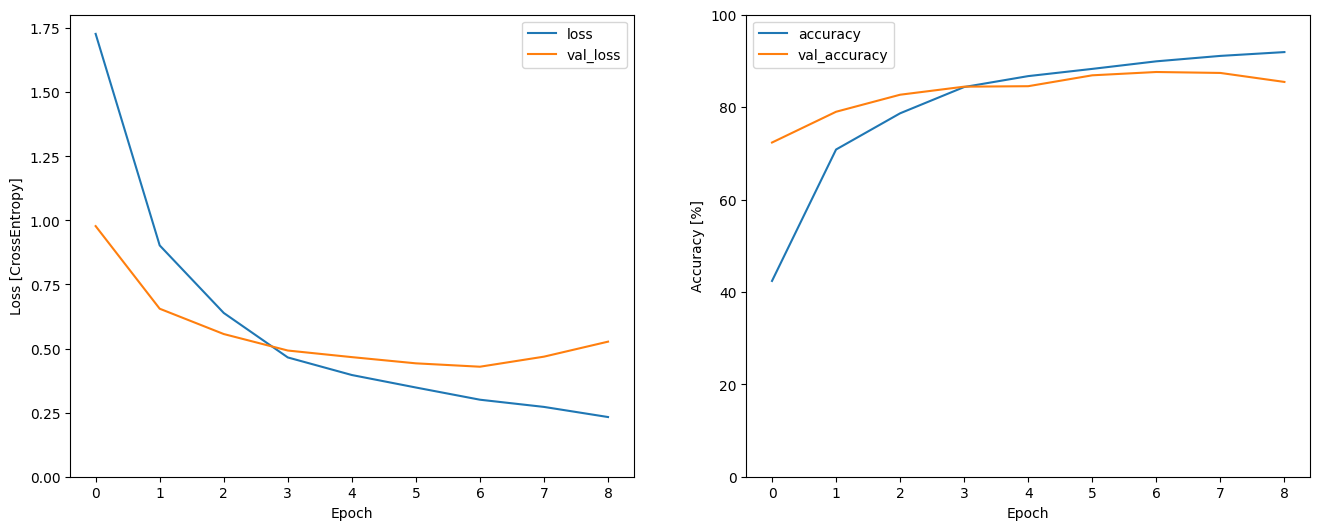

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [23]:
model.evaluate(test_spectrogram_ds, return_dict=True)

16/16 [==============================] - 6s 342ms/step - loss: 0.3644 - accuracy: 0.8984


{'loss': 0.36439722776412964, 'accuracy': 0.8984375}

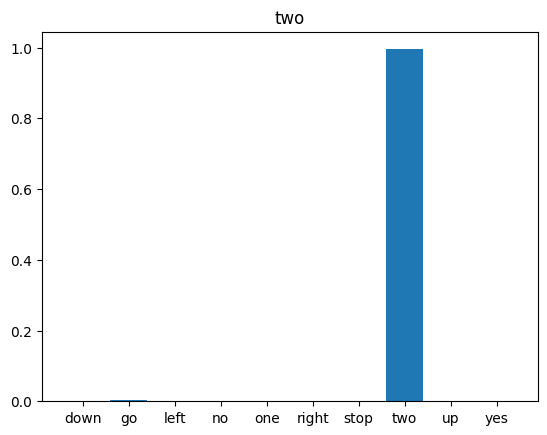

In [29]:
# x = data_dir/'no/012c8314_nohash_0.wav'
# x = data_dir/'one/0a2b400e_nohash_0.wav'
x = data_dir/'two/0a5636ca_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
lable_prediction = np.argmax(prediction, axis=1)
x_labels = [ 'down', 'go','left','no', 'one', 'right', 'stop', 'two', 'up',  'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(x_labels[lable_prediction[0]])
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [30]:
model.save('saved_model2')

INFO:tensorflow:Assets written to: saved_model2\assets


INFO:tensorflow:Assets written to: saved_model2\assets


## mic input and processing

In [27]:
import pyaudio
import wave

In [28]:
CHUNK = 3200 #samples per data frame
sample_format = pyaudio.paInt16
channels = 1
fs = 16000
fileName = 'recording.wav'

In [29]:
p = pyaudio.PyAudio()
p.get_device_info_by_index(device_index=1)

{'index': 1,
 'structVersion': 2,
 'name': 'Microphone Array (Realtek High ',
 'hostApi': 0,
 'maxInputChannels': 2,
 'maxOutputChannels': 0,
 'defaultLowInputLatency': 0.09,
 'defaultLowOutputLatency': 0.09,
 'defaultHighInputLatency': 0.18,
 'defaultHighOutputLatency': 0.18,
 'defaultSampleRate': 44100.0}

### input

In [1]:
print("recording")
stream = p.open(format=sample_format, channels=1, rate=fs, frames_per_buffer=CHUNK, input=True, input_device_index=1)

frames = []
seconds = 1

for i in range(0, int(fs/CHUNK * seconds)):
  data = stream.read(CHUNK)
  frames.append(data)

stream.stop_stream()
stream.close()

p.terminate()

print("finished")

wf = wave.open(fileName, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

recording


NameError: name 'p' is not defined

### convert to spectogram

tf.Tensor(
[[ 0.0000000e+00]
 [ 0.0000000e+00]
 [-3.0517578e-05]
 ...
 [ 1.7089844e-03]
 [ 1.0375977e-03]
 [-1.2817383e-03]], shape=(16000, 1), dtype=float32)


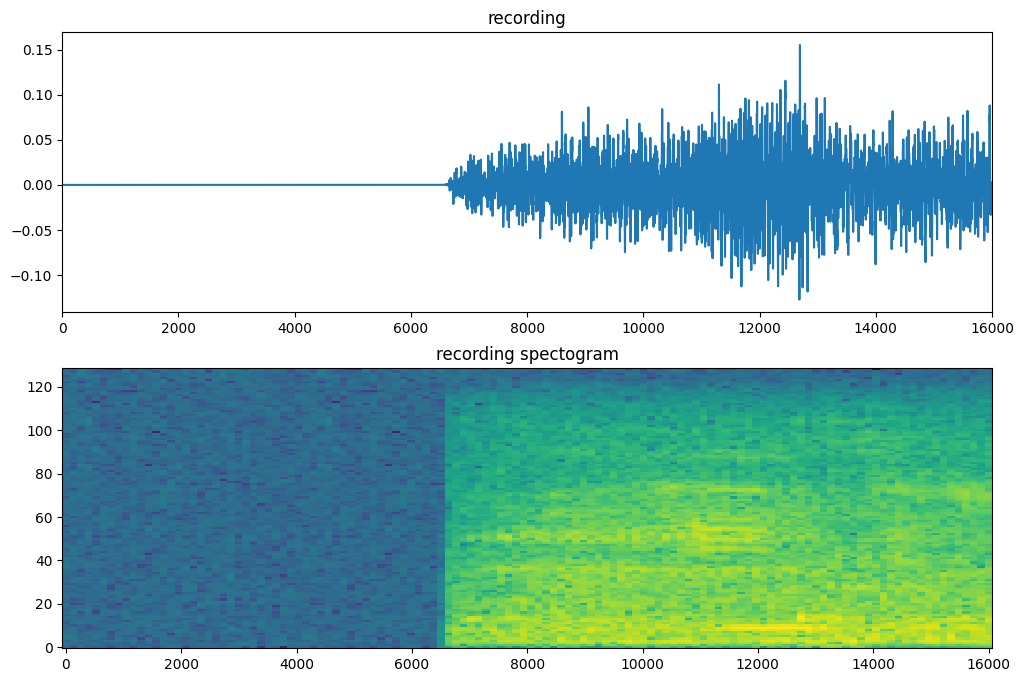

In [31]:
recording = tf.io.read_file(str(fileName))
recording, sample_rate = tf.audio.decode_wav(recording, desired_channels=1, desired_samples=-1,)
print(recording)
recording = tf.squeeze(recording, axis=-1)
spectrogram = get_spectrogram(recording)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(recording.shape[0])

axes[0].plot(timescale, recording.numpy())
axes[0].set_title('recording')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('recording spectogram')
plt.show()

### give it to model

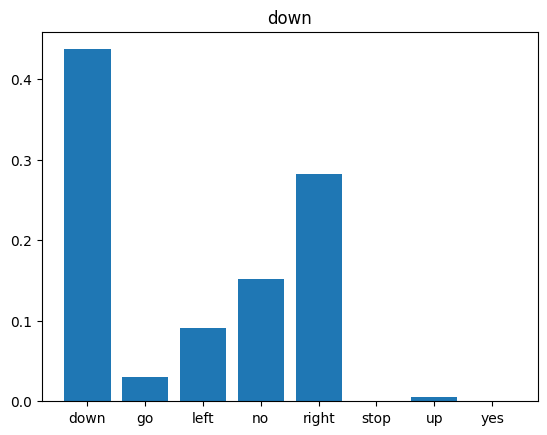

In [32]:
spectrogram = spectrogram[tf.newaxis,...]
prediction = model(spectrogram)
lable_prediction = np.argmax(prediction, axis=1)
x_labels = [ 'down', 'go','left','no', 'one', 'right', 'stop', 'two', 'up',  'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(x_labels[lable_prediction[0]])
plt.show()

display.display(display.Audio(waveform, rate=48000))